# Add expansion output to low-rate aging simulation

In [ ]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.style.use('seaborn-white')

eSOH_DIR = "./data/esoh/"
oCV_DIR = "./data/ocv/"
fig_DIR = "./figures/"
res_DIR = "./data/results/"
%matplotlib widget

In [ ]:
def nmc_volume_change_mohtat(sto):
    t_change = -1.10/100*(1-sto)
    return t_change

def graphite_volume_change_mohtat(sto):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    x = [sto]
    t_change = pybamm.Interpolant(stoichpoints, thicknesspoints, x, name=None, interpolator='linear', extrapolate=True, entries_string=None)
    return t_change

def get_parameter_values():
    parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
    parameter_values.update(
        {
            # mechanical properties
            "Positive electrode Poisson's ratio": 0.3,
            "Positive electrode Young's modulus [Pa]": 375e9,
            "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
            "Positive electrode volume change": nmc_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Positive electrode LAM constant exponential term": 2,
            "Positive electrode critical stress [Pa]": 375e6,
            # mechanical properties
            "Negative electrode Poisson's ratio": 0.2,
            "Negative electrode Young's modulus [Pa]": 15e9,
            "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
            "Negative electrode volume change": graphite_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode critical stress [Pa]": 60e6,
            # Other
            "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
            "Lower voltage cut-off [V]": 3.0
        },
        check_already_exists=False,
    )
    return parameter_values
parameter_values = get_parameter_values()

In [ ]:
parameter_values.search("Li")

In [ ]:
def split_long_string(title, max_words=None):
    """Get title in a nice format"""
    max_words = max_words or pybamm.settings.max_words_in_line
    words = title.split()
    # Don't split if fits on one line, don't split just for units
    if len(words) <= max_words or words[max_words].startswith("["):
        return title
    else:
        first_line = (" ").join(words[:max_words])
        second_line = (" ").join(words[max_words:])
        return first_line + "\n" + second_line

In [ ]:
def cycle_adaptive_simulation(model, parameter_values, experiment,SOC_0=1, save_at_cycles=None):
    experiment_one_cycle = pybamm.Experiment(
        experiment.operating_conditions_cycles[:1],
        termination=experiment.termination_string,
        cccv_handling=experiment.cccv_handling,
    )
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = parameter_values.evaluate(param.C_n_init)
    Cp = parameter_values.evaluate(param.C_p_init)
    eps_n = parameter_values["Negative electrode active material volume fraction"]
    eps_p = parameter_values["Positive electrode active material volume fraction"]
    C_over_eps_n = Cn / eps_n
    C_over_eps_p = Cp / eps_p
    c_n_max = parameter_values.evaluate(param.c_n_max)
    c_p_max = parameter_values.evaluate(param.c_p_max)
    n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)
    
    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
                "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            
        }
    )

    sim_ode = pybamm.Simulation(
        model, experiment=experiment_one_cycle, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol0 = sim_ode.solve(initial_soc=SOC_0)
    model = sim_ode.solution.all_models[0]
    cap0 = sol0.summary_variables["Capacity [A.h]"]

    def sol_to_y(sol, loc="end"):
        if loc == "start":
            pos = 0
        elif loc == "end":
            pos = -1
        model = sol.all_models[0]
        n_Li = sol["Total lithium in particles [mol]"].data[pos].flatten()
        Cn = sol["Negative electrode capacity [A.h]"].data[pos].flatten()
        Cp = sol["Positive electrode capacity [A.h]"].data[pos].flatten()
        # y = np.concatenate([n_Li, Cn, Cp])
        y = n_Li
        for var in model.initial_conditions:
            if var.name not in [
                "X-averaged negative particle concentration",
                "X-averaged positive particle concentration",
                "Discharge capacity [A.h]",
            ]:
                value = sol[var.name].data
                if value.ndim == 1:
                    value = value[pos]
                elif value.ndim == 2:
                    value = value[:, pos]
                elif value.ndim == 3:
                    value = value[:, :, pos]
                y = np.concatenate([y, value.flatten()])
        return y

    def y_to_sol(y, esoh_sim, model):
        n_Li = y[0]
        Cn = C_over_eps_n * y[1]
        Cp = C_over_eps_p * y[2]

        esoh_sol = esoh_sim.solve(
            [0],
            inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
        )
        esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
        ics = {}
        x_100 = esoh_sol["x_100"].data[0]
        y_100 = esoh_sol["y_100"].data[0]
        x_0 = esoh_sol["x_0"].data[0]
        y_0 = esoh_sol["y_0"].data[0]
        start = 1
        for var in model.initial_conditions:
            if var.name == "X-averaged negative particle concentration":
                ics[var.name] = ((x_100-x_0)*SOC_0+x_0) * np.ones((model.variables[var.name].size, 2))
            elif var.name == "X-averaged positive particle concentration":
                ics[var.name] = y_100 * np.ones((model.variables[var.name].size, 2))
            elif var.name == "Discharge capacity [A.h]":
                ics[var.name] = np.zeros(1)
            else:
                end = start + model.variables[var.name].size
                ics[var.name] = y[start:end, np.newaxis]
                start = end
        model.set_initial_conditions_from(ics)
        return pybamm.Solution(
            [np.array([0])],
            model.concatenated_initial_conditions.evaluate()[:, np.newaxis],
            model,
            {},
        )

    def dydt(t, y):
        if y[0] < 0 or y[1] < 0 or y[2] < 0:
            return 0 * y

        # print(t)
        # Set up based on current value of y
        y_to_sol(
            y,
            esoh_sim,
            sim_ode.op_conds_to_built_models[
                experiment_one_cycle.operating_conditions[0]["electric"]
            ],
        )

        # Simulate one cycle
        sol = sim_ode.solve()

        dy = sol_to_y(sol) - y

        return dy

    if experiment.termination == {}:
        event = None
    else:

        def capacity_cutoff(t, y):
            sol = y_to_sol(y, esoh_sim, model)
            cap = pybamm.make_cycle_solution([sol], esoh_sim, True)[1]["Capacity [A.h]"]
            return cap / cap0 - experiment_one_cycle.termination["capacity"][0] / 100

        capacity_cutoff.terminal = True

    num_cycles = len(experiment.operating_conditions_cycles)
    if save_at_cycles is None:
        t_eval = np.arange(1, num_cycles + 1)
    elif save_at_cycles == -1:
        t_eval = None
    else:
        t_eval = np.arange(1, num_cycles + 1, save_at_cycles)
    y0 = sol_to_y(sol0, loc="start")
    timer = pybamm.Timer()
    sol = solve_ivp(
        dydt,
        [1, num_cycles],
        y0,
        t_eval=t_eval,
        events=capacity_cutoff,
        first_step=10,
        method="RK23",
        atol=1e-2,
        rtol=1e-2,
    )
    time = timer.time()

    all_sumvars = []
    for idx in range(sol.y.shape[1]):
        fullsol = y_to_sol(sol.y[:, idx], esoh_sim, model)
        sumvars = pybamm.make_cycle_solution([fullsol], esoh_sim, True)[1]
        all_sumvars.append(sumvars)

    all_sumvars_dict = {
        key: np.array([sumvars[key] for sumvars in all_sumvars])
        for key in all_sumvars[0].keys()
    }
    all_sumvars_dict["Cycle number"] = sol.t
    
    all_sumvars_dict["cycles evaluated"] = sol.nfev
    all_sumvars_dict["solution time"] = time
    
    return all_sumvars_dict

In [43]:
def plot(all_sumvars_dict,esoh_data):
    esoh_vars = ["x_0", "y_0", "x_100", "y_100", "C_n", "C_p"]
    # esoh_vars = ["Capacity [A.h]", "Loss of lithium inventory [%]",
    #              "Loss of active material in negative electrode [%]",
    #              "Loss of active material in positive electrode [%]"]
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
#         ax.scatter(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],color="r")
    #     ax.plot(long_sol.summary_variables[name],"b-")
        ax.set_title(split_long_string(name))
        if k>3:
            ax.set_xlabel("Cycle number")
    # fig.subplots_adjust(bottom=0.4)
    fig.legend(["Acc Sim"] + ["Reported"], 
           loc="lower center", ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

def plot1(all_sumvars_dict,esoh_data):
    esoh_vars = ["Capacity [A.h]","n_Li"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    fig, axes = plt.subplots(2,1,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        ax.set_xlabel("Cycle number")
    fig.legend(["Acc Sim"] + ["Reported"], 
           loc="upper right", ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

In [ ]:
cell = 1

## Load eSOH Data and OCV Data

In [ ]:
cell_no = f'{cell:02d}'
dfe=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
N =dfe.N.unique()
dfo_0=pd.read_csv(oCV_DIR+"ocv_data_cell_"+cell_no+".csv")
print("Cycle Numbers:")
print(*N, sep = ", ") 

In [ ]:
dfo = dfo_0[dfo_0['N']==N[0]]
# dfe_0 = dfe[dfe['N']==N[0]]
C_n_init = dfe['C_n'][0]
C_p_init = dfe['C_p'][0]
y_0_init = dfe['y_0'][0] 
if cell_no=='01':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " until 3V"
    eps_n_data = 0.6234
    eps_p_data = 0.4542
elif cell_no=='13':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " for 150 min"

In [ ]:
dfe.N.iloc[-1]

In [ ]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    termination="50% capacity",
#     cccv_handling="ode",
)
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()

In [ ]:
param = spm.param
eps_n_data = parameter_values.evaluate(C_n_init*3600/(param.L_n * param.c_n_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(C_p_init*3600/(param.L_p * param.c_p_max * param.F* param.A_cc))
cs_p_init = parameter_values.evaluate(y_0_init* param.c_p_max)

In [ ]:
parameter_values = get_parameter_values()
sim_des = '_lowc'
parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        "Positive electrode LAM constant proportional term [s-1]": 8.3569e-6,
        "Negative electrode LAM constant proportional term [s-1]": 5.8032e-5,
        "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
    },
    check_already_exists=False,
)
all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment, save_at_cycles=2)

In [ ]:
print(all_sumvars_dict["cycles evaluated"])
print(all_sumvars_dict["solution time"])

In [ ]:
fig = plot(all_sumvars_dict,dfe);
fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_new.png')

In [ ]:
fig = plot1(all_sumvars_dict,dfe);
fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_cap_new.png')

# Parameter Fitting

In [ ]:
cycles = np.array(dfe['N'].astype('int'))
cycles=cycles-1
cycles[0]=cycles[0]+1
cycles
dfe['N_mod'] = cycles

In [58]:
cycles

array([  0,  40,  58,  97, 133, 174, 215, 256, 297, 338, 379])

In [59]:
def objective(model, data):
    return np.array(model.loc[data['N_mod']]["Capacity [A.h]"]) - np.array(data["Cap"])

def multi_objective(model, data):
    variables = ["C_n","C_p","x_100","y_0"]
    # variables = ["Capacity [A.h]", "C_n"]
    weights = [1,1,5,5]
    return np.concatenate([
        (np.array(model.loc[data['N_mod']][var]) - np.array(data[var])) * w
        for w,var in zip(weights,variables)
    ]
    )

def simulate(x,expt):
    parameter_values = get_parameter_values()
    parameter_values.update(
        {
            "SEI kinetic rate constant [m.s-1]":  x[2]*1.7e-16,
            "Positive electrode LAM constant proportional term [s-1]": x[0]*2e-2/3600,
            "Negative electrode LAM constant proportional term [s-1]": x[1]*2e-1/3600,
            "EC diffusivity [m2.s-1]": 2e-18,
            "Positive electrode LAM constant exponential term": 2,
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
        },
        check_already_exists=False,
    )
    Cn = parameter_values.evaluate(param.C_n_init)
    Cp = parameter_values.evaluate(param.C_p_init)
    eps_n = parameter_values["Negative electrode active material volume fraction"]
    eps_p = parameter_values["Positive electrode active material volume fraction"]
    C_over_eps_n = Cn / eps_n
    C_over_eps_p = Cp / eps_p
    return cycle_adaptive_simulation(spm, parameter_values, expt,save_at_cycles=1)
def prediction_error(x,data,expt):
    model = simulate(x,expt)
    try:
        out = multi_objective(pd.DataFrame(model), data)
    except pybamm.SolverError:
        return 10*np.ones_like(np.concatenate([np.array(data['Cap'])]*4))
    print(f"x={x}, norm={np.linalg.norm(out)}")
    return out


In [60]:
def train_model(data,expt):
    timer = pybamm.Timer()
    x0 = np.array([1.0,1.0,1.0])
    # print(prediction_error(x0))
    soln_dfols = dfols.solve(prediction_error, x0,args=(data,expt), rhoend=1e-4)
    print(timer.time())
    return soln_dfols

In [62]:
def sim_train(dfe,experiment,df,train_len):
    sim_des = str(train_len)
    data_train = dfe.iloc[:train_len]
    experiment_train = pybamm.Experiment(
        [
            ("Discharge at "+c_rate_d+dis_set,
            "Rest for 5 min",
            "Charge at "+c_rate_c+" until 4.2V", 
            "Hold at 4.2V until C/50")
        ] *data_train.N.iloc[-1],
        termination="50% capacity",
    #     cccv_handling="ode",
    )
    soln_dfols = train_model(data_train,experiment_train)
    xsol = soln_dfols.x
    # print(xsol[0]*2e-2/3600)
    # print(xsol[1]*2e-1/3600)
    # print(xsol[2]*1.6e-16)\
    df['x_0'][train_len]=xsol[0]
    df['x_1'][train_len]=xsol[1]
    df['x_2'][train_len]=xsol[2]

    sol_out = simulate(soln_dfols.x,experiment_train)
    fig = plot(sol_out,data_train);
    fig.savefig(fig_DIR + "fit_train_" + sim_des +"_eSOH.png")
    fig = plot1(sol_out,data_train);
    fig.savefig(fig_DIR + "fit_train_" + sim_des +"_cap.png")
    sol_full = simulate(soln_dfols.x,experiment)
    fig = plot(sol_full,dfe);
    fig.savefig(fig_DIR + "fit_pred_" + sim_des +"_eSOH.png")
    fig = plot1(sol_full,dfe);
    fig.savefig(fig_DIR + "fit_pred_" + sim_des +"_cap.png")
    return df

x=[1. 1. 1.], norm=0.5832667106951426
x=[1.1 1.  1. ], norm=0.5493083529005587
x=[1.  1.1 1. ], norm=0.6479373504215046
x=[1.  1.  1.1], norm=0.581294608634607
x=[1.19730344 0.98855721 1.02002757], norm=0.5162553623892835
x=[1.59079466 1.00889689 1.08895477], norm=0.4274806421870423
x=[1.80640072 1.02301859 1.10374622], norm=0.4139028315268414
x=[1.80070724 1.02338196 1.10416481], norm=0.4138749499101244
x=[1.80062675 1.02386647 1.11269293], norm=0.41390774096125615
x=[1.80130209 1.03334849 1.10360419], norm=0.4144303841192554
x=[1.79820012 1.02371826 1.10546419], norm=0.41387042212151676
x=[1.79827768 1.02474295 1.10541714], norm=0.41387649703934726
x=[1.79826052 1.02374303 1.10547266], norm=0.4138704198808793
x=[1.79823628 1.02375165 1.10562043], norm=0.41387043566278936
x=[1.79822414 1.02383565 1.10546128], norm=0.4138704706165261
x=[1.79820223 1.02374205 1.10546358], norm=0.41387042062897067
15 minutes, 24 seconds
x=[1. 1. 1.], norm=0.6076136146389258
x=[1.1 1.  1. ], norm=0.567292

SolverError: Could not determine which event was triggered (possibly due to NaNs)

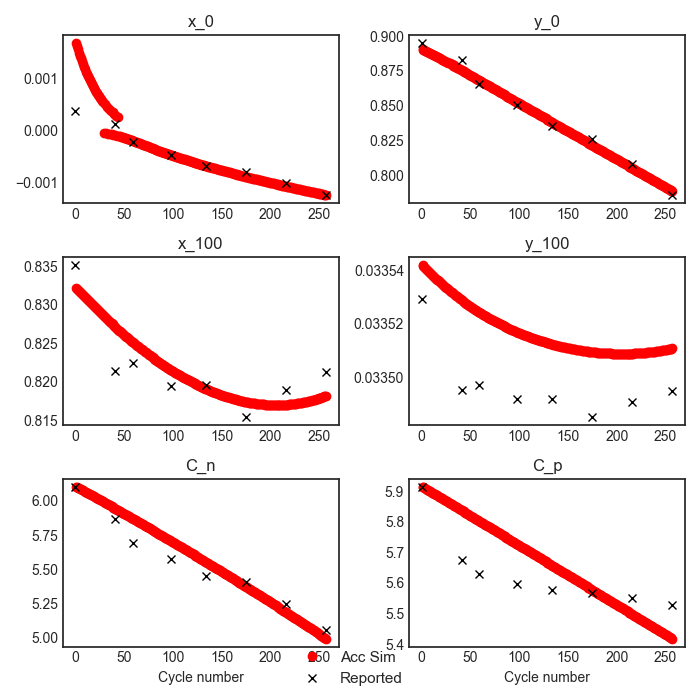

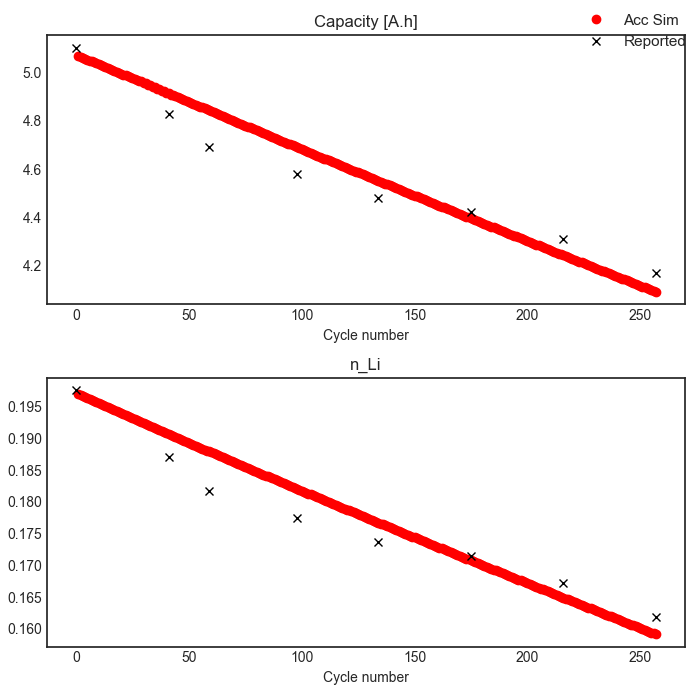

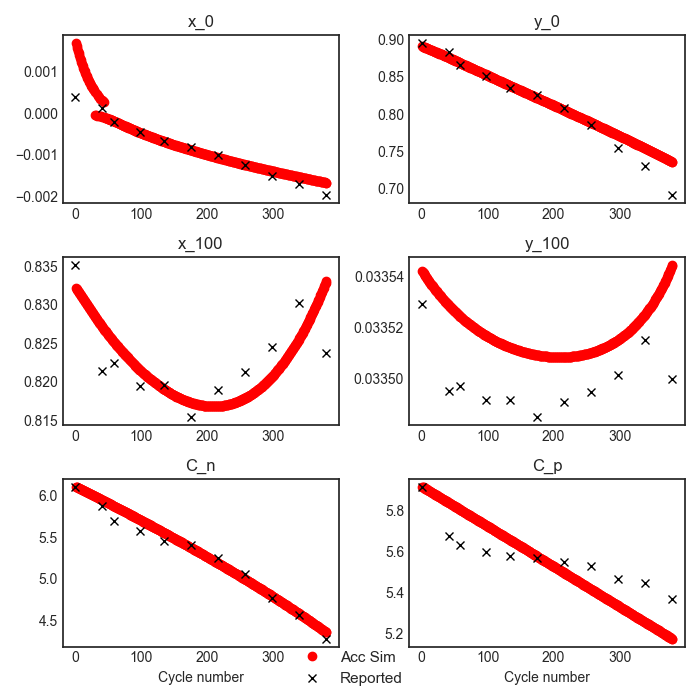

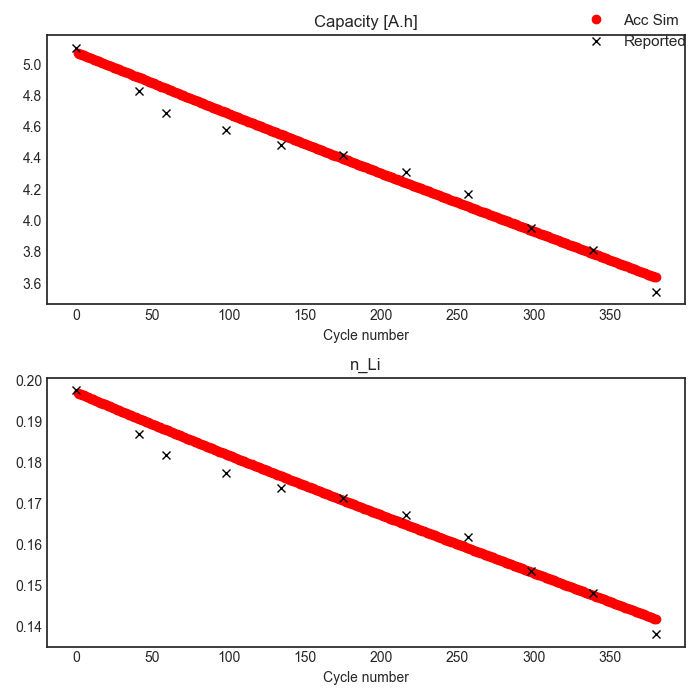

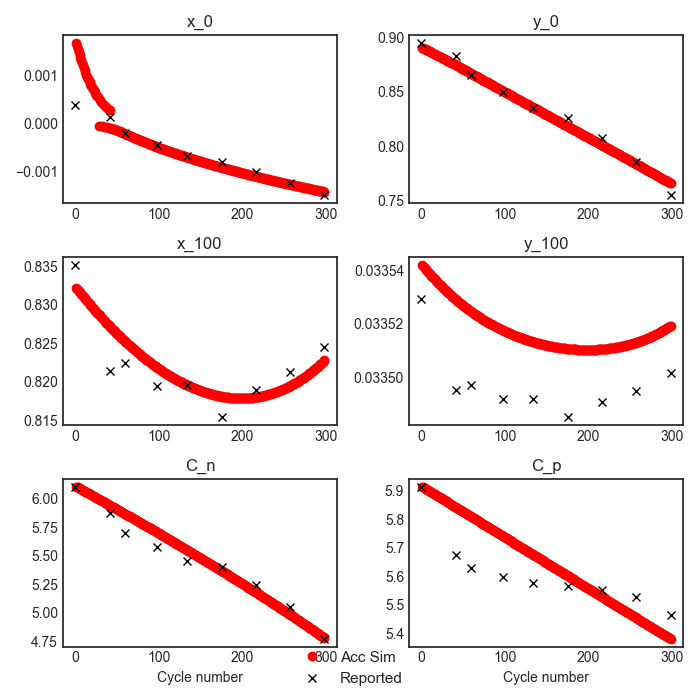

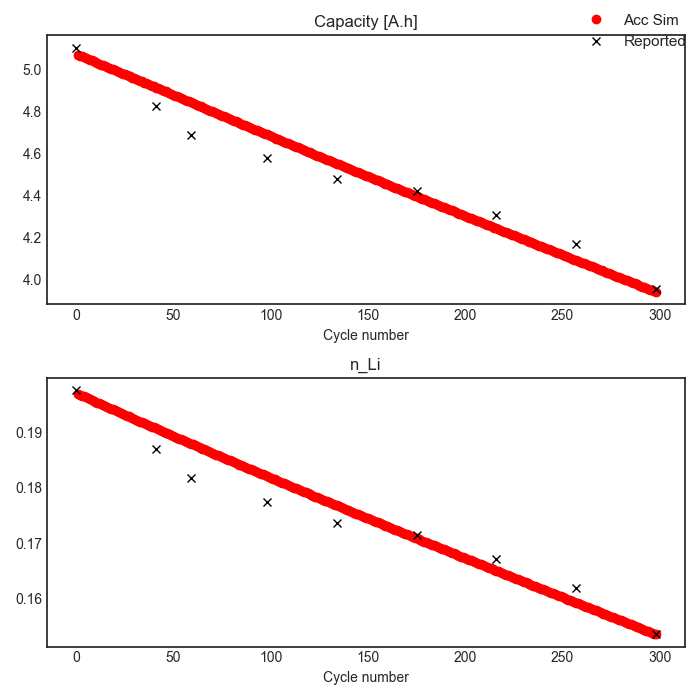

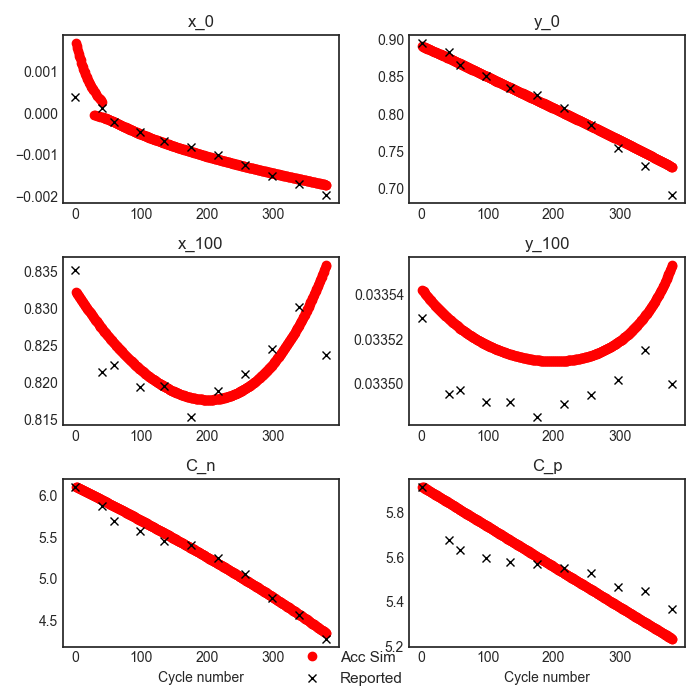

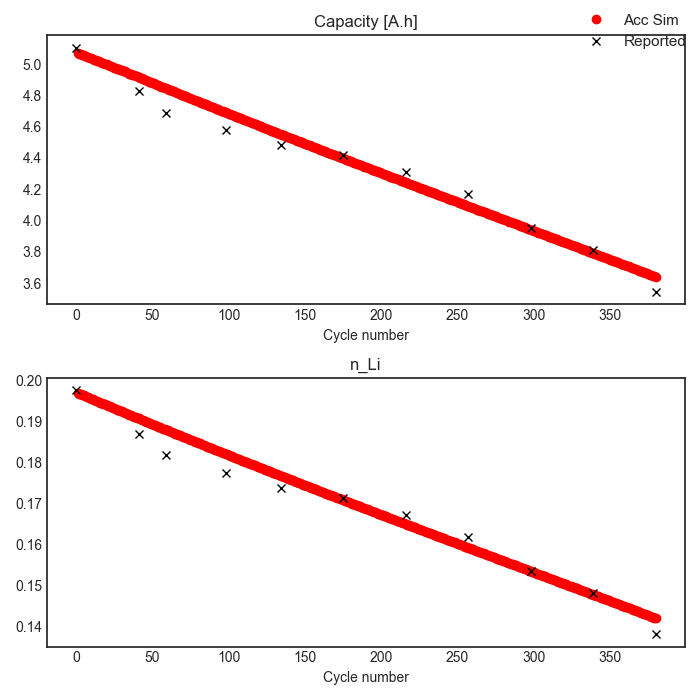

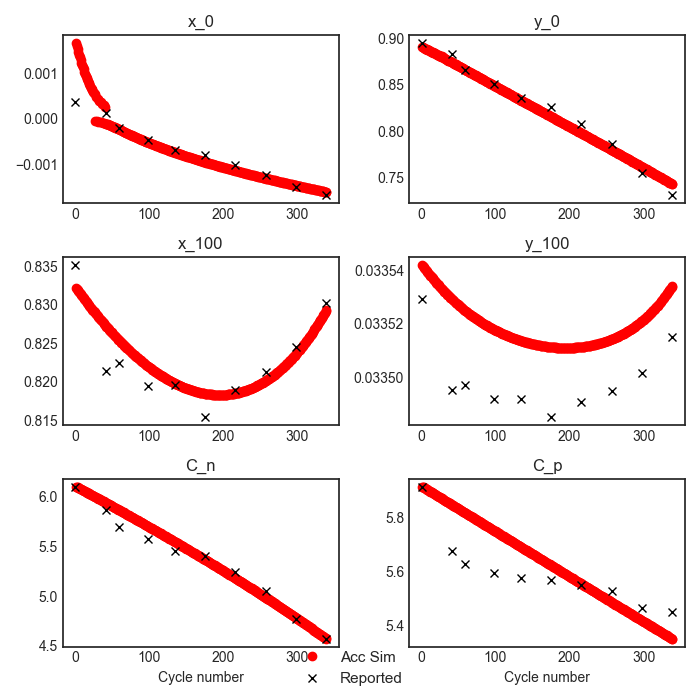

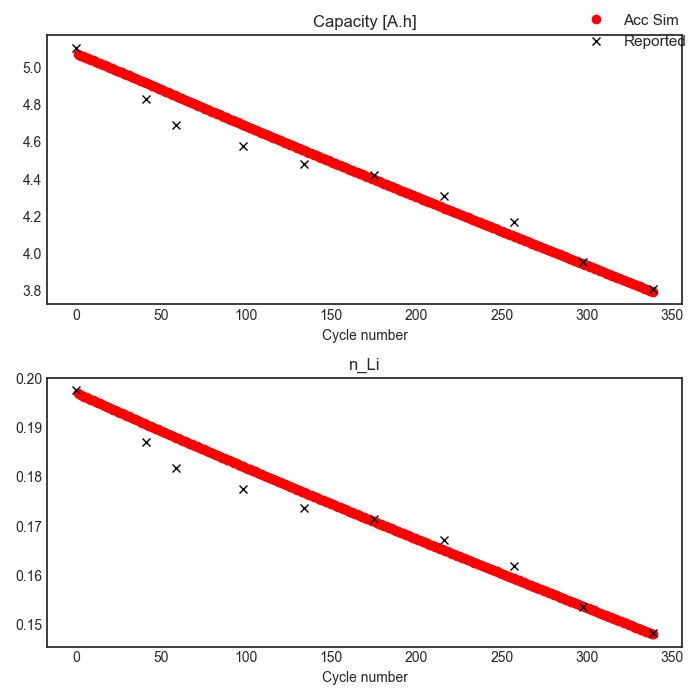

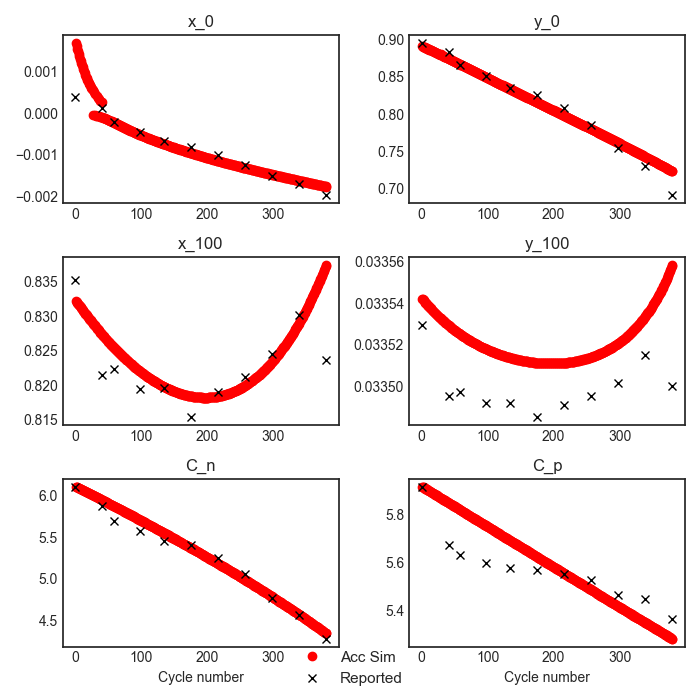

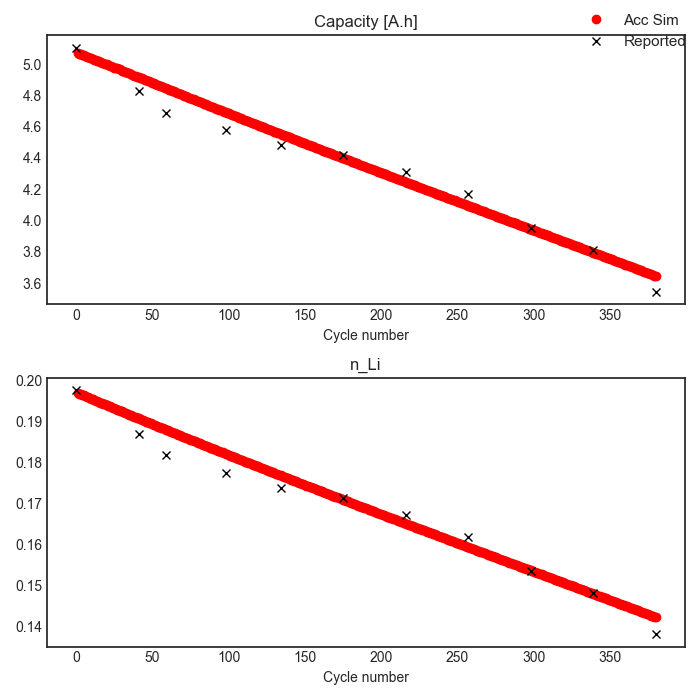

In [65]:
df_x = pd.DataFrame(columns=['x_0','x_1','x_2'], index=range(len(N)))
for train_len in range(8,len(N)+1):
    df_x = sim_train(dfe,experiment,df_x,train_len)

In [ ]:
# d = sol_out
# df = pd.DataFrame.from_dict(d, )
# df.to_csv(res_DIR + "fit_cycling_" + sim_des +".csv")